<a href="https://colab.research.google.com/github/jmend01/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/Jonathan_Mendoza_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [22]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [21]:
import numpy as np

np.random.normal(10, 2)

12.799903538634878

In [23]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [24]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
#   time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60,2.5*30)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(8*60, 2*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=True, time_on_site=598.8740950160811, mobile=True),
 User(purchased=True, time_on_site=584.6623274810817, mobile=True),
 User(purchased=True, time_on_site=835.4439905374934, mobile=True),
 User(purchased=False, time_on_site=407.35016671271063, mobile=True),
 User(purchased=False, time_on_site=526.3922407161638, mobile=False),
 User(purchased=True, time_on_site=722.3447845135727, mobile=True),
 User(purchased=False, time_on_site=409.17711959031794, mobile=True),
 User(purchased=True, time_on_site=689.6770781594859, mobile=True),
 User(purchased=False, time_on_site=524.3441066663414, mobile=True),
 User(purchased=False, time_on_site=594.6197968267686, mobile=False)]

In [25]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,598.874095,True
1,True,584.662327,True
2,True,835.443991,True
3,False,407.350167,True
4,False,526.392241,False


In [26]:
user_data['time_on_site_mins'] = user_data['time_on_site']/60

user_data.head()

,purchased,time_on_site,mobile,time_on_site_mins
0,True,598.874095,True,9.981235
1,True,584.662327,True,9.744372
2,True,835.443991,True,13.924067
3,False,407.350167,True,6.789169
4,False,526.392241,False,8.773204


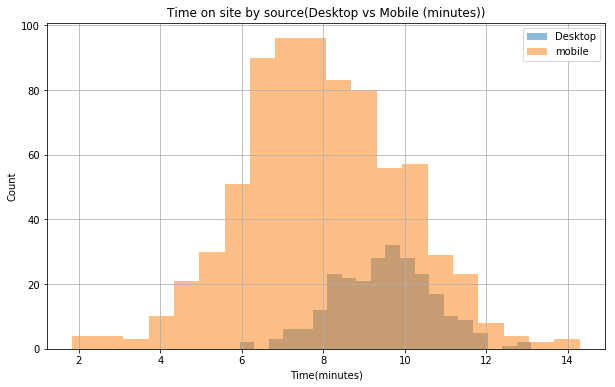

In [29]:
import matplotlib.pyplot as plt
user_data.groupby('mobile').time_on_site_mins.hist(bins = 20, alpha =0.5, figsize = (10,6))
plt.title('Time on site by source(Desktop vs Mobile (minutes))')
plt.ylabel('Count')
plt.xlabel('Time(minutes)')
plt.legend(['Desktop','mobile'])

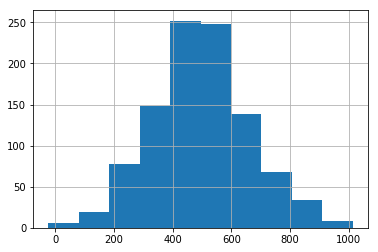

In [0]:
user_data.time_on_site.hist()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-22.663850682030272,14.72455038314979,44.17095529985352,54.63171328774837,67.83678315583427,77.4608636540533,88.78346664777263,96.03364659323296,98.89978378367084,105.46481133056659,109.3380213858373,111.21427362879632,122.01177298764384,131.84542961686253,134.71439194162463,140.34103140363692,154.59986058463176,160.1903015221091,168.1169300922893,178.36474513174937,178.87081368538207,180.1791585595949,181.02371737313206,181.26624293285522,183.44725449509139,194.0643342400092,197.55478013885795,198.55595558769414,205.1506448364354,205.93602340668878,205.9400802647134,210.2480185147416,212.8380193142848,213.7794448173073,216.18300881513687,218.1147724542742,221.38897349727552,221.87563615078517,226.16324044439412,226.20355922630677,...,807.0948900153128,808.4263409101285,809.559122391466,811.3120531199495,812.9490034117822,812.9796956568473,814.0461228959593,816.2288082292362,820.6218554080024,820.7463254192835,822.9302284335206,823.4791961548957,823.5535172125266,824.0779150072856,827.0172202954363,827.361385510634,829.4874586890585,832.4400870577197,832.7559758289841,836.5124003019723,838.4316360013003,843.9671283977575,849.3440264958824,851.5141051837985,855.40269892069,859.3753936643925,869.7314845915523,870.3867566507893,888.7725013694937,889.2218730244301,900.8006835218199,908.4001560777128,912.9777784991479,925.0512246087454,964.5421508554532,966.497147151289,975.9158503948281,994.9078131320862,1008.4001469221946,1013.6878643221422
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,1,0,0,0,1,1,0,...,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1
True,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,1,1,0,0,1,...,1,1,1,0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_mins'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site_mins,,
"(-0.395, 3.077]",14,11
"(3.077, 6.531]",117,109
"(6.531, 9.986]",211,289
"(9.986, 13.44]",74,133
"(13.44, 16.895]",16,26


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins,user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_mins,,
"(-0.395, 3.077]",0.032407,0.019366
"(3.077, 6.531]",0.270833,0.191901
"(6.531, 9.986]",0.488426,0.508803
"(9.986, 13.44]",0.171296,0.234155
"(13.44, 16.895]",0.037037,0.045775


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.528,0.4
True,0.472,0.6


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins,[user_data['purchased'],user_data['mobile']], normalize = 'columns')

purchased             False               True           
mobile                False     True      False     True 
time_on_site_mins                                        
(-0.395, 3.077]    0.015152  0.040000  0.008475  0.022222
(3.077, 6.531]     0.166667  0.316667  0.110169  0.213333
(6.531, 9.986]     0.446970  0.506667  0.398305  0.537778
(9.986, 13.44]     0.280303  0.123333  0.347458  0.204444
(13.44, 16.895]    0.090909  0.013333  0.135593  0.022222

## Stanford open police project

https://openpolicing.stanford.edu


In [0]:
!unzip /content/tr137st9964_tx_san_antonio_2019_02_25.csv.zip

Archive:  /content/tr137st9964_tx_san_antonio_2019_02_25.csv.zip
  inflating: share/data/opp-for-archive/tx_san_antonio_2019_02_25.csv  


In [0]:
!ls

sample_data  share  tr137st9964_tx_san_antonio_2019_02_25.csv.zip


In [0]:
%%time
df = pd.read_csv('/content/share/data/opp-for-archive/tx_san_antonio_2019_02_25.csv')


<string>:2: DtypeWarning: Columns (15,17) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 8.68 s, sys: 801 ms, total: 9.48 s
Wall time: 9.49 s


In [0]:
print(df.shape)
df.head()

(1357705, 26)


,raw_row_number,date,time,location,lat,lng,district,substation,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,outcome,contraband_found,search_conducted,search_basis,reason_for_stop,speed,posted_speed,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state,vehicle_year
0,1,2012-01-01,00:50:00,300 E COMMERCE,29.423899,-98.489756,2110.0,CENTRAL,20.0,hispanic,male,pedestrian,NaN,True,citation,NaN,False,NaN,POSSESSION OF ALCOHOL BY A MINOR,0,0,NaN,NaN,NaN,NaN,NaN
1,2,2012-01-01,00:50:00,300 E COMMERCE,29.423899,-98.489756,2110.0,CENTRAL,20.0,hispanic,male,pedestrian,NaN,True,citation,NaN,False,NaN,CONSUMPTION OF ALCOHOL BY A MINOR,0,0,NaN,NaN,NaN,NaN,NaN
2,3,2012-01-01,21:00:00,500 N ST MARY,29.429013,-98.491064,2130.0,CENTRAL,37.0,white,female,pedestrian,NaN,True,citation,NaN,False,NaN,CONSUMING IN THE CENTRAL BUSINESS DISTRICT,0,0,NaN,NaN,NaN,NaN,NaN
3,4,2012-01-01,12:51:00,100 BROADWAY,29.426530,-98.488001,2130.0,CENTRAL,48.0,black,male,pedestrian,NaN,True,citation,NaN,False,NaN,SITTING OR LYING DOWN IN RIGHT OF WAY,0,0,NaN,NaN,NaN,NaN,NaN
4,5,2012-01-03,11:50:00,300 FOURTH,29.429674,-98.486039,2130.0,CENTRAL,46.0,white,male,pedestrian,NaN,True,citation,NaN,False,NaN,CONSUMING IN THE CENTRAL BUSINESS DISTRICT,0,0,NaN,NaN,NaN,NaN,NaN


In [0]:
df.isna().sum()

raw_row_number                      0
date                                0
time                                0
location                            3
lat                              1994
lng                              1994
district                        99956
substation                      99956
subject_age                      1340
subject_race                      492
subject_sex                      3077
type                            21054
arrest_made                   1119713
citation_issued                     0
outcome                             0
contraband_found              1341240
search_conducted                    0
search_basis                  1341109
reason_for_stop                     7
speed                               0
posted_speed                        0
vehicle_color                  178947
vehicle_make                   173307
vehicle_model                  181369
vehicle_registration_state     175722
vehicle_year                   190551
dtype: int64

In [0]:
df.reason_for_stop.value_counts().head()

SPEEDING-POSTED LIMIT                                472939
OPERATING A MOTOR VEHICLE WITHOUT A VALID LICENSE    112025
DRIVING WITHOUT PROOF OF FINANCIAL RESPONSIBILITY     87967
SPEEDING IN SCHOOL ZONE                               68807
USE OF HAND-HELD MOBILE COMMUNICATION DEVICE          48353
Name: reason_for_stop, dtype: int64

In [0]:
df.vehicle_make.value_counts(normalize =True).head()

FORD    0.172408
CHEV    0.152685
TOY     0.083572
DODG    0.076965
NISS    0.065433
Name: vehicle_make, dtype: float64

In [0]:
df[df['reason_for_stop'] == 'SPEEDING-POSTED LIMIT'].vehicle_make.value_counts(normalize=True).head()

FORD    0.160804
CHEV    0.136742
TOY     0.101635
NISS    0.073219
DODG    0.073051
Name: vehicle_make, dtype: float64

In [0]:
df[df['reason_for_stop'] == 'SPEEDING-POSTED LIMIT'].vehicle_color.value_counts(normalize=True).head()

BLACK     0.208982
WHITE     0.195044
SILVER    0.154995
GRAY      0.107669
BLUE      0.080041
Name: vehicle_color, dtype: float64

In [0]:
df = pd.DataFrame({'a': np.arange(1e6),
                 'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [0]:
%timeit df['c'] = df['a']**2

100 loops, best of 3: 14 ms per loop


In [0]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)
## its faster to run the code without the apply function

1 loop, best of 3: 315 ms per loop


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

!pip install pandas==0.23.4 #downgrade pandas version to enable crosstab for two binned features

df = pd.read_csv('https://raw.githubusercontent.com/jmend01/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')

print(df.shape) #checking out the data
print(df.info())
df.head()

(1200, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
Unnamed: 0       1200 non-null int64
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(4)
memory usage: 37.6 KB
None


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [23]:
# df.isna().sum()
# df.weight.min()
# df.weight.mean()
# df.weight.max()
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


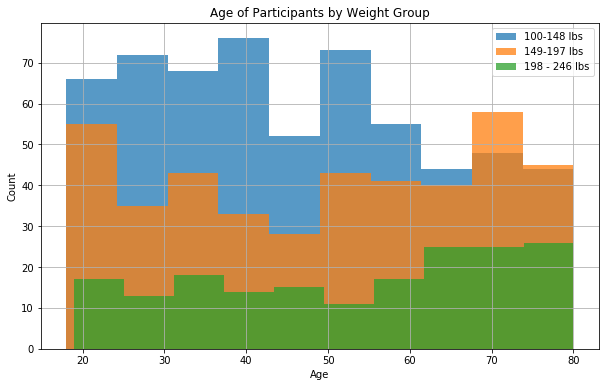

In [6]:
wt_bins = pd.cut(df['weight'], 3)  #binning data 

df.groupby(wt_bins).age.hist(alpha = 0.75, figsize = (10,6))
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(['100-148 lbs','149-197 lbs','198 - 246 lbs'])
plt.title ('Age of Participants by Weight Group')
plt.show()

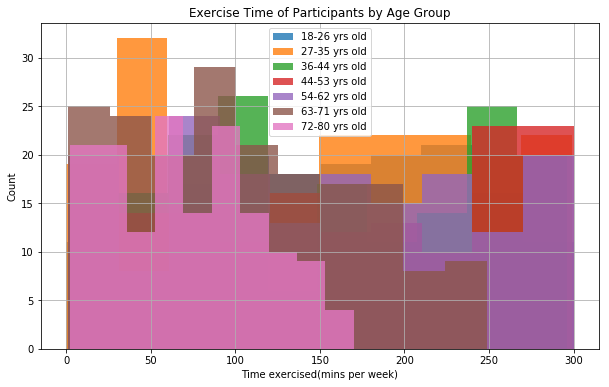

In [7]:
age_bins = pd.cut(df['age'],7)
df.groupby(age_bins).exercise_time.hist(figsize=(10,6),alpha = 0.8)
plt.xlabel('Time exercised(mins per week)')
plt.ylabel('Count')
plt.legend(['18-26 yrs old','27-35 yrs old','36-44 yrs old','44-53 yrs old','54-62 yrs old','63-71 yrs old','72-80 yrs old'])
plt.title ('Exercise Time of Participants by Age Group')
plt.show()

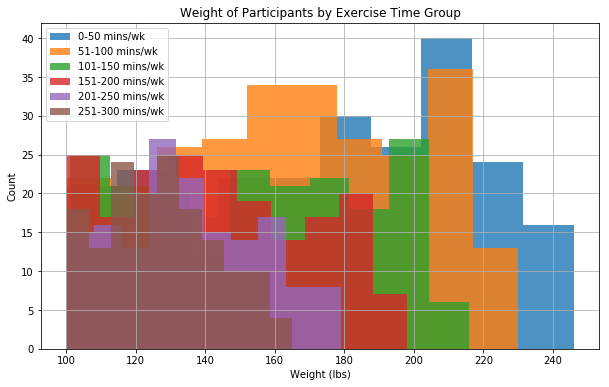

In [8]:
ex_bins = pd.cut(df['exercise_time'],6)
df.groupby(ex_bins).weight.hist(figsize=(10,6), alpha = 0.8)
plt.xlabel('Weight (lbs)')
plt.ylabel('Count')
plt.legend(['0-50 mins/wk','51-100 mins/wk','101-150 mins/wk','151-200 mins/wk','201-250 mins/wk','251-300 mins/wk'])
plt.title ('Weight of Participants by Exercise Time Group')
plt.show()

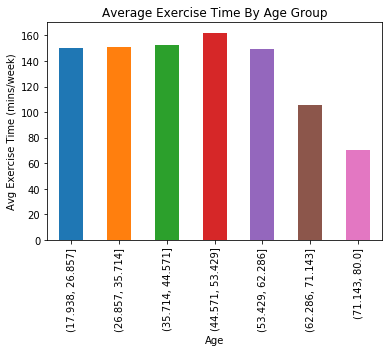

In [9]:
df.groupby(age_bins).exercise_time.mean().plot.bar()
plt.xlabel('Age')
plt.ylabel('Avg Exercise Time (mins/week)')
plt.title('Average Exercise Time By Age Group')
plt.show()

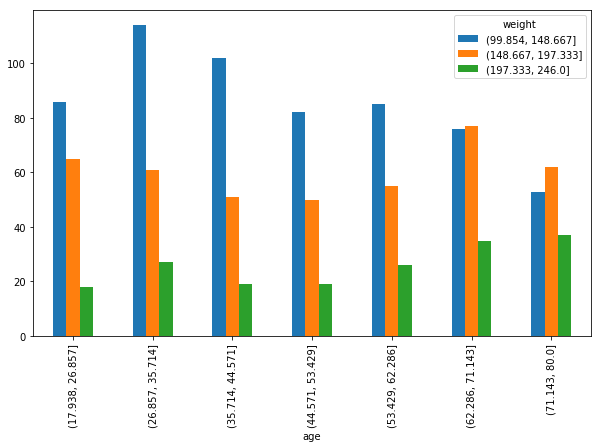

In [18]:
pd.crosstab(age_bins, wt_bins).plot.bar(figsize = (10,6))


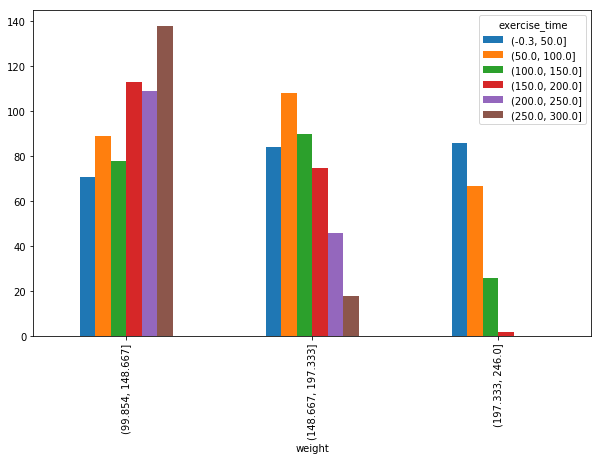

In [17]:
pd.crosstab(wt_bins, ex_bins).plot.bar(figsize = (10,6))


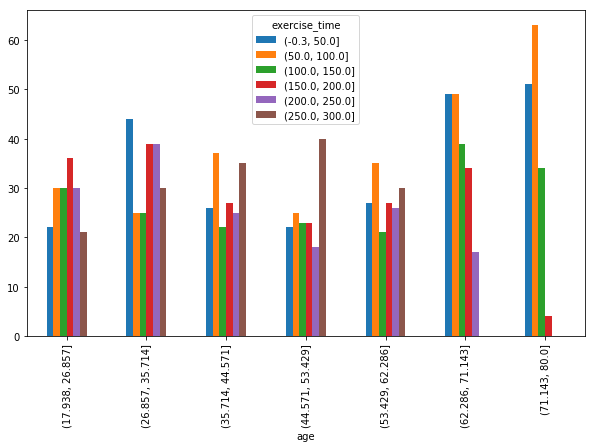

In [21]:
pd.crosstab(age_bins, ex_bins).plot.bar(figsize = (10,6))


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

integers (discreet values)

2.  What are the relationships between the variables?

We can see an inverse relationship between weight and exerise time, and both the 'age vs exercise' and 'age vs weight' times have direct relationships which can probably be modeled using  polynomial functions. 

3.  Which relationships are "real", and which spurious?

age vs weight is spurious, while weight vs exercise time is a real relationship


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)